In [5]:
import warnings
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [248]:
#reading in the file
#The file path is unfortunetly still hardcoded to my desktop
df = pd.read_csv(r"C:\Users\m_was\OneDrive\Skrivbord\Machine Learning\project_data.csv")
#if you want to use more common path use this instead: df = pd.read_csv("project_data.csv")

**EDA**  

*Summary:*
There are 19 columns in total, containing  11 numerical and 8 categorical attributes.  
11,8% of original dataset is removed.


In column "Unnamed: 0" there is lack of information what this column accctualy contains. Since we are unable to find information about it at this point. Whole column and data it cointains will be removed.

Columns "Administrative", "Informational", "ProductRelated" will be dropped fully. They contain number of pages of their type that the user visited.

Column "PageValue" already contains the total number of pageviews according to following formulas:  

Page Value = (Transaction Revenue + Total Goal Value) / Unique Pageviews for the page  
Page Value can also be calculated for a group of pages, like a directory. In that case the definition changes slightly.  
Page Value = (Transaction Revenue + Total Goal Value) / Total unique Pageviews for the group of pages    


Column "Administrative_Duration" seem to contian outliers. The 75% percentile is at 93 and the maximam value is 989493. Those will be removed.

Column "BounceRates" also contains invalid data. The value represents "percentage of visitors who enter the website through that page". Negative values and values above 1 are invalid and needs to be removed or replaced.

Non numerical columns "SpecialDay", "Browser", "Revenue" contain a plentiful ammount of NaN values and needs to be take care of accordinly.                 

Column "Month" contains strings of months they will be encoded with numerical value. That was the first thought, but on closer inspection the column appears to contain alot corrupt/invalid data. It will be dropped alltogheter.

In [249]:
df.head()

,Unnamed: 0,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,NaN,1.0,1,Returning_Visitor,False,False
1,1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2.0,NaN,2,Returning_Visitor,False,False
2,2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1.0,NaN,3,Returning_Visitor,False,False
3,3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2.0,2.0,4,Returning_Visitor,False,False
4,4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3.0,1.0,4,Returning_Visitor,True,False


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               12330 non-null  int64  
 1   Administrative           12330 non-null  int64  
 2   Administrative_Duration  12330 non-null  float64
 3   Informational            12330 non-null  int64  
 4   Informational_Duration   12330 non-null  float64
 5   ProductRelated           12330 non-null  int64  
 6   ProductRelated_Duration  12330 non-null  float64
 7   BounceRates              12330 non-null  float64
 8   ExitRates                12330 non-null  float64
 9   PageValues               12330 non-null  float64
 10  SpecialDay               12207 non-null  float64
 11  Month                    12330 non-null  object 
 12  OperatingSystems         12330 non-null  int64  
 13  Browser                  12146 non-null  float64
 14  Region                

There are 19 columns in total, containing  11 numerical and 8 categorical attributes. Numerical columns can be futher looked into by useing function describe().

**Information about features**

Administrative: Number of administrative pages visited by the user. 
Administrative_Duration: Time spent on administrative pages.    
Informational: Number of informational pages visited by the user.   
Informational_Duration: Time spent on informational pages.  
ProductRelated: Number of product-related pages visited by the user.    
ProductRelated_Duration: Time spent on product-related pages.   
BounceRates: Percentage of visitors who exit the website after viewing a single page.   
ExitRates: Percentage of page views that end at a specific page.    
PageValues: Average value of a page, considering its influence on the target page or eCommerce transaction completion.  
SpecialDay: Proximity of the browsing date to special days or holidays, affecting transaction likelihood.   
Month: Month of the page view.  
OperatingSystems: Integer representing the user's operating system. 
Browser: Integer representing the user's browser.   
Region: Integer representing the user's region. 
TrafficType: Integer representing the type of traffic the user belongs to.  
VisitorType: New Visitor, Returning Visitor, or Other.  
Weekend: Boolean indicating whether the session occurred on a weekend.  
Revenue: Boolean indicating whether the user completed a purchase   

In [251]:
df.describe()
#We can observe some outliers here

,Unnamed: 0,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12207.00000,12330.000000,12146.000000,12084.000000,12330.000000
mean,6164.500000,2.238200,1269.776004,0.503569,34.472398,31.731468,1194.746220,0.044239,0.043073,5.889258,0.06126,2.124006,2.360283,3.145647,4.069586
std,3559.508744,3.409269,34071.466930,1.270156,140.749294,44.475503,1913.669288,0.239735,0.048597,18.568437,0.19865,0.911325,1.722001,2.402440,4.025169
min,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.498680,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000
25%,3082.250000,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.00000,2.000000,2.000000,1.000000,2.000000
50%,6164.500000,1.000000,8.000000,0.000000,0.000000,18.000000,598.936905,0.002896,0.025156,0.000000,0.00000,2.000000,2.000000,3.000000,2.000000
75%,9246.750000,4.000000,93.787500,0.000000,0.000000,38.000000,1464.157214,0.018029,0.050000,0.000000,0.00000,3.000000,2.000000,4.000000,4.000000
max,12329.000000,27.000000,989493.000000,24.000000,2549.375000,705.000000,63973.522230,2.098952,0.200000,361.763742,1.00000,8.000000,13.000000,9.000000,20.000000


In [252]:
df.isnull().sum()

Unnamed: 0                   0
Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 123
Month                        0
OperatingSystems             0
Browser                    184
Region                     246
TrafficType                  0
VisitorType                  0
Weekend                      0
Revenue                    147
dtype: int64

In [253]:
#Dropping columns
df_clean = df.drop(['Unnamed: 0','Administrative', 'Informational', 'ProductRelated','Month'], axis=1)
#removing outlier
df_clean = df_clean[df_clean['Administrative_Duration'] <= 10000]
#cleaning "BounceRates" of invalid data
df_clean = df_clean[df_clean["BounceRates"]<= 1]
df_clean = df_clean[df_clean["BounceRates"]>= 0]
#removing string "Zara" from "Weekend"
df_clean.loc[df_clean['Weekend'] == 'Name:Zara', 'Weekend'] = np.nan

In [254]:
#droping rows containing NaN values
df_final = df_clean.dropna()

In [255]:
ammount_dropped = round(((1- (len(df_final)/len(df)))* 100), 3)
#thats 11,8% of original dataset gone.
print(f"Ammount of data removed: {ammount_dropped} %")

Ammount of data removed: 11.719 %


**Visualisation of some key metrics**

Variables below stores values used to calculate revenues for diffrent cathegories.
The graphs represent the count of revenue for different groups in the dataset. Each graph focuses on a specific group and shows the count of revenue (represented by the bars) for each category within that group. 

In [256]:
# Grouping data for visualization
import operator
traffic = df_final.groupby('TrafficType')['Revenue'].value_counts()
special_day = df_final.groupby('SpecialDay')['Revenue'].value_counts()
region = df_final.groupby('Region')['Revenue'].value_counts()
visitor_type = df_final.groupby('VisitorType')['Revenue'].value_counts()
weekend = df_final.groupby('Weekend')['Revenue'].value_counts()
browser = df_final.groupby('Browser')['Revenue'].value_counts()
operating_system = df_final.groupby('OperatingSystems')['Revenue'].value_counts()

In [257]:
group_columns = ['TrafficType', 'SpecialDay', 'Region', 'VisitorType', 'Weekend', 'Browser', 'OperatingSystems']

def plot_count_of_revenue(df_final, group_column):
    # Calculate value counts of 'Revenue' within each group
    group_revenue_counts = df_final.groupby(group_column)['Revenue'].value_counts()

    # Plot the results
    group_revenue_counts.unstack().plot(kind='bar', stacked=True, color=['blue', 'orange'])
    plt.xlabel(group_column)
    plt.ylabel('Count of Revenue')
    plt.title('Count of Revenue by ' + group_column)
    plt.xticks(rotation=0)
    plt.legend(title='Revenue')
    plt.show()


<Axes: xlabel='VisitorType'>

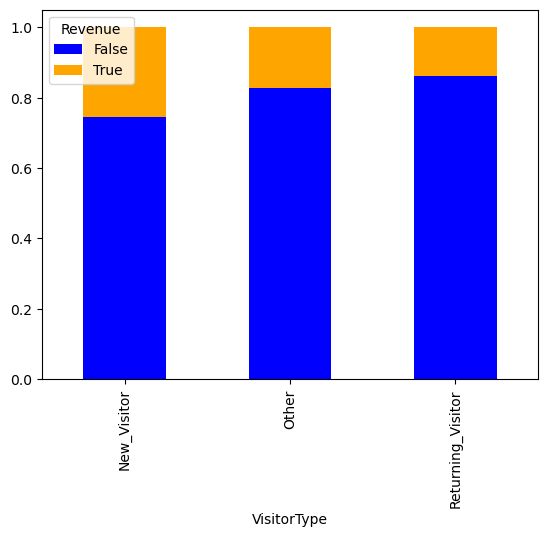

In [264]:
#checking for revenue as % of costumer type
visitor_type_percent = df_final.groupby('VisitorType')['Revenue'].value_counts(normalize=True).unstack()
visitor_type_percent.plot(kind='bar', stacked=True, color=['blue', 'orange'])   

<Axes: xlabel='Region'>

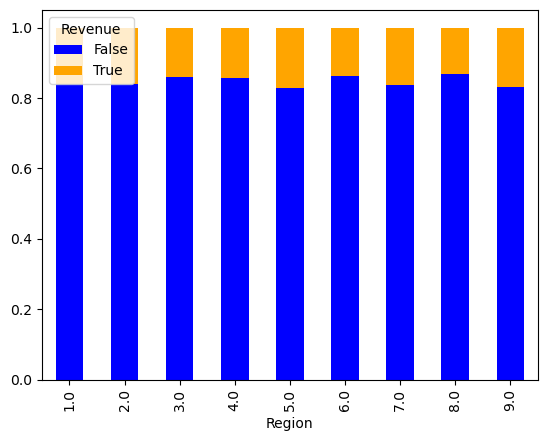

In [265]:
region_percent = df_final.groupby('Region')['Revenue'].value_counts(normalize=True).unstack()
region_percent.plot(kind='bar', stacked=True, color=['blue', 'orange'])

<Axes: xlabel='OperatingSystems'>

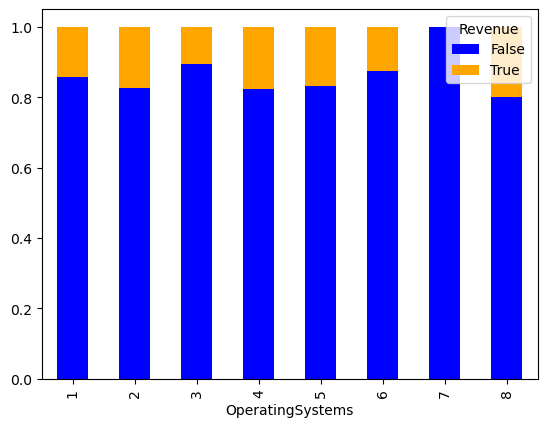

In [267]:
operating_system_percent = df_final.groupby('OperatingSystems')['Revenue'].value_counts(normalize=True).unstack()
operating_system_percent.plot(kind='bar', stacked=True, color=['blue', 'orange'])

<Axes: xlabel='Browser'>

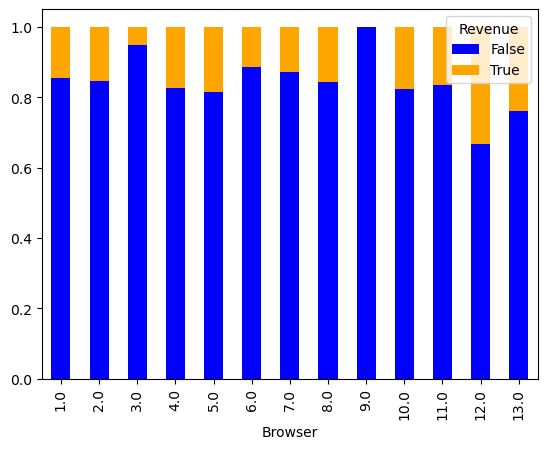

In [268]:
browser_percent = df_final.groupby('Browser')['Revenue'].value_counts(normalize=True).unstack() 
browser_percent.plot(kind='bar', stacked=True, color=['blue', 'orange'])


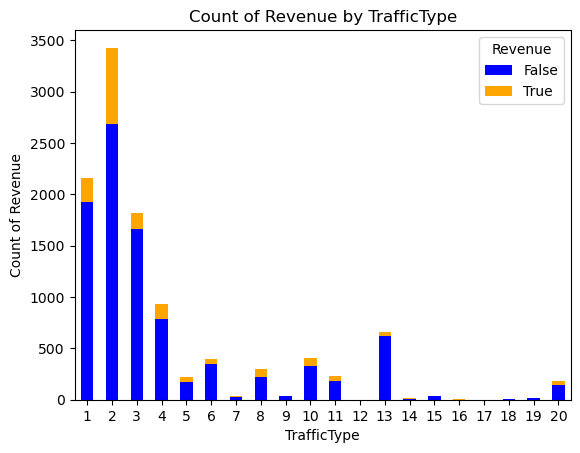

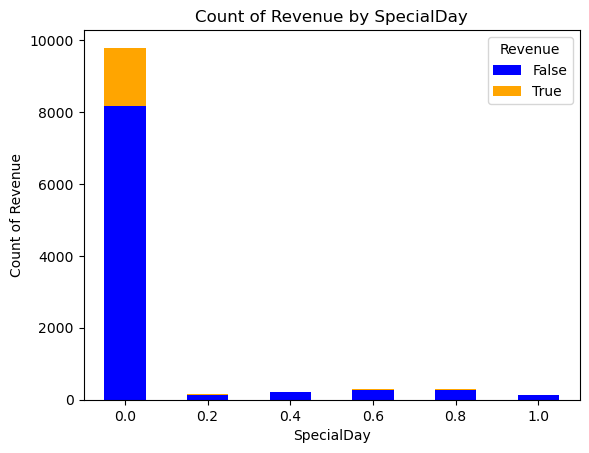

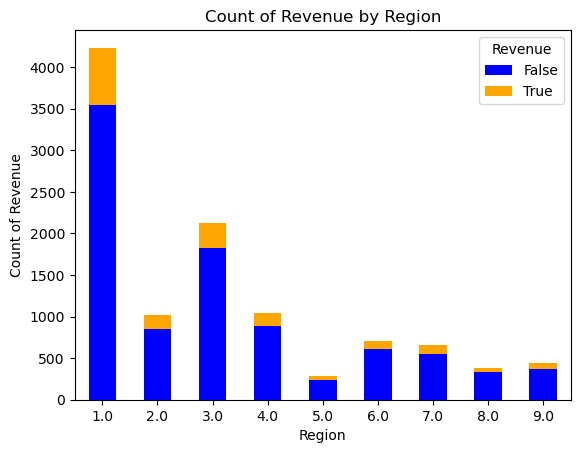

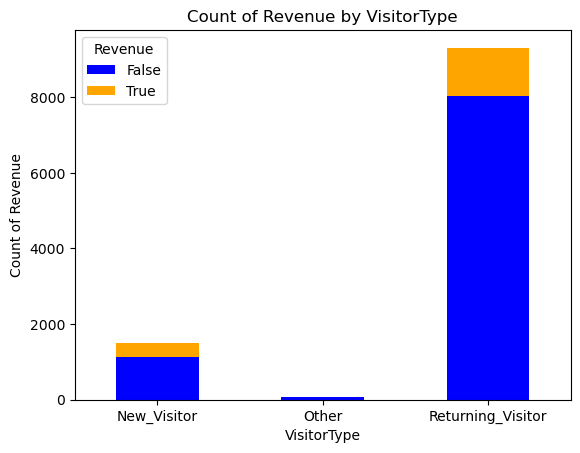

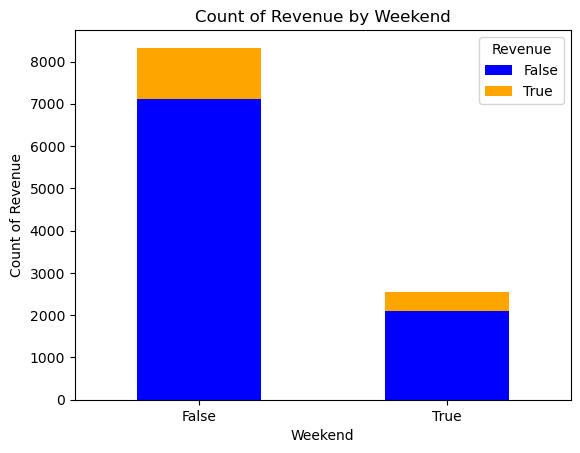

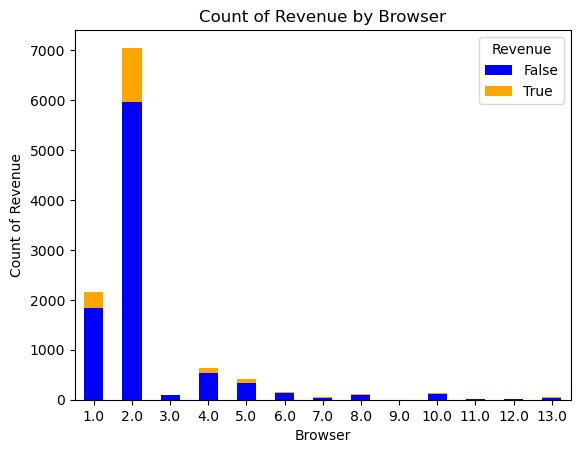

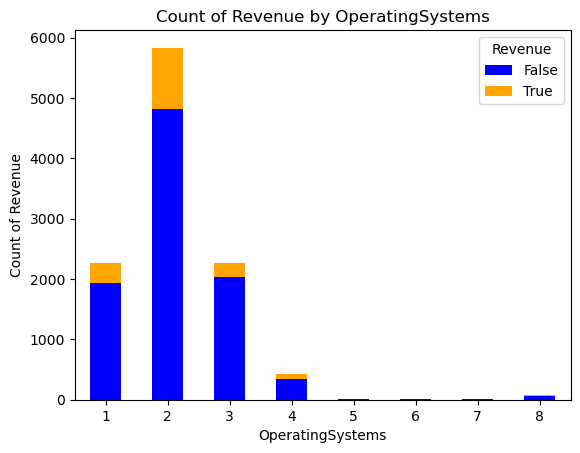

In [258]:
# Plot the count of revenue for each group
for column in group_columns:
    plot_count_of_revenue(df_final, column)



**Key takeaways:**

Traffic type 2 is the biggest type and it also brings the biggest revenue.      
Sales are not dependent of special holiday days.    
Region 1 and 3 brings most traffic but also most sales. 
Returning costumers are more likely to do a purchase again. 
Most sale (total ammount) are done during weekdays, allthough we should consider lenght of weekend vs weekday.  
Operating system and type of browser have an influence on the sales conversion.
New constumers have higher conversion rate than returning costumers.




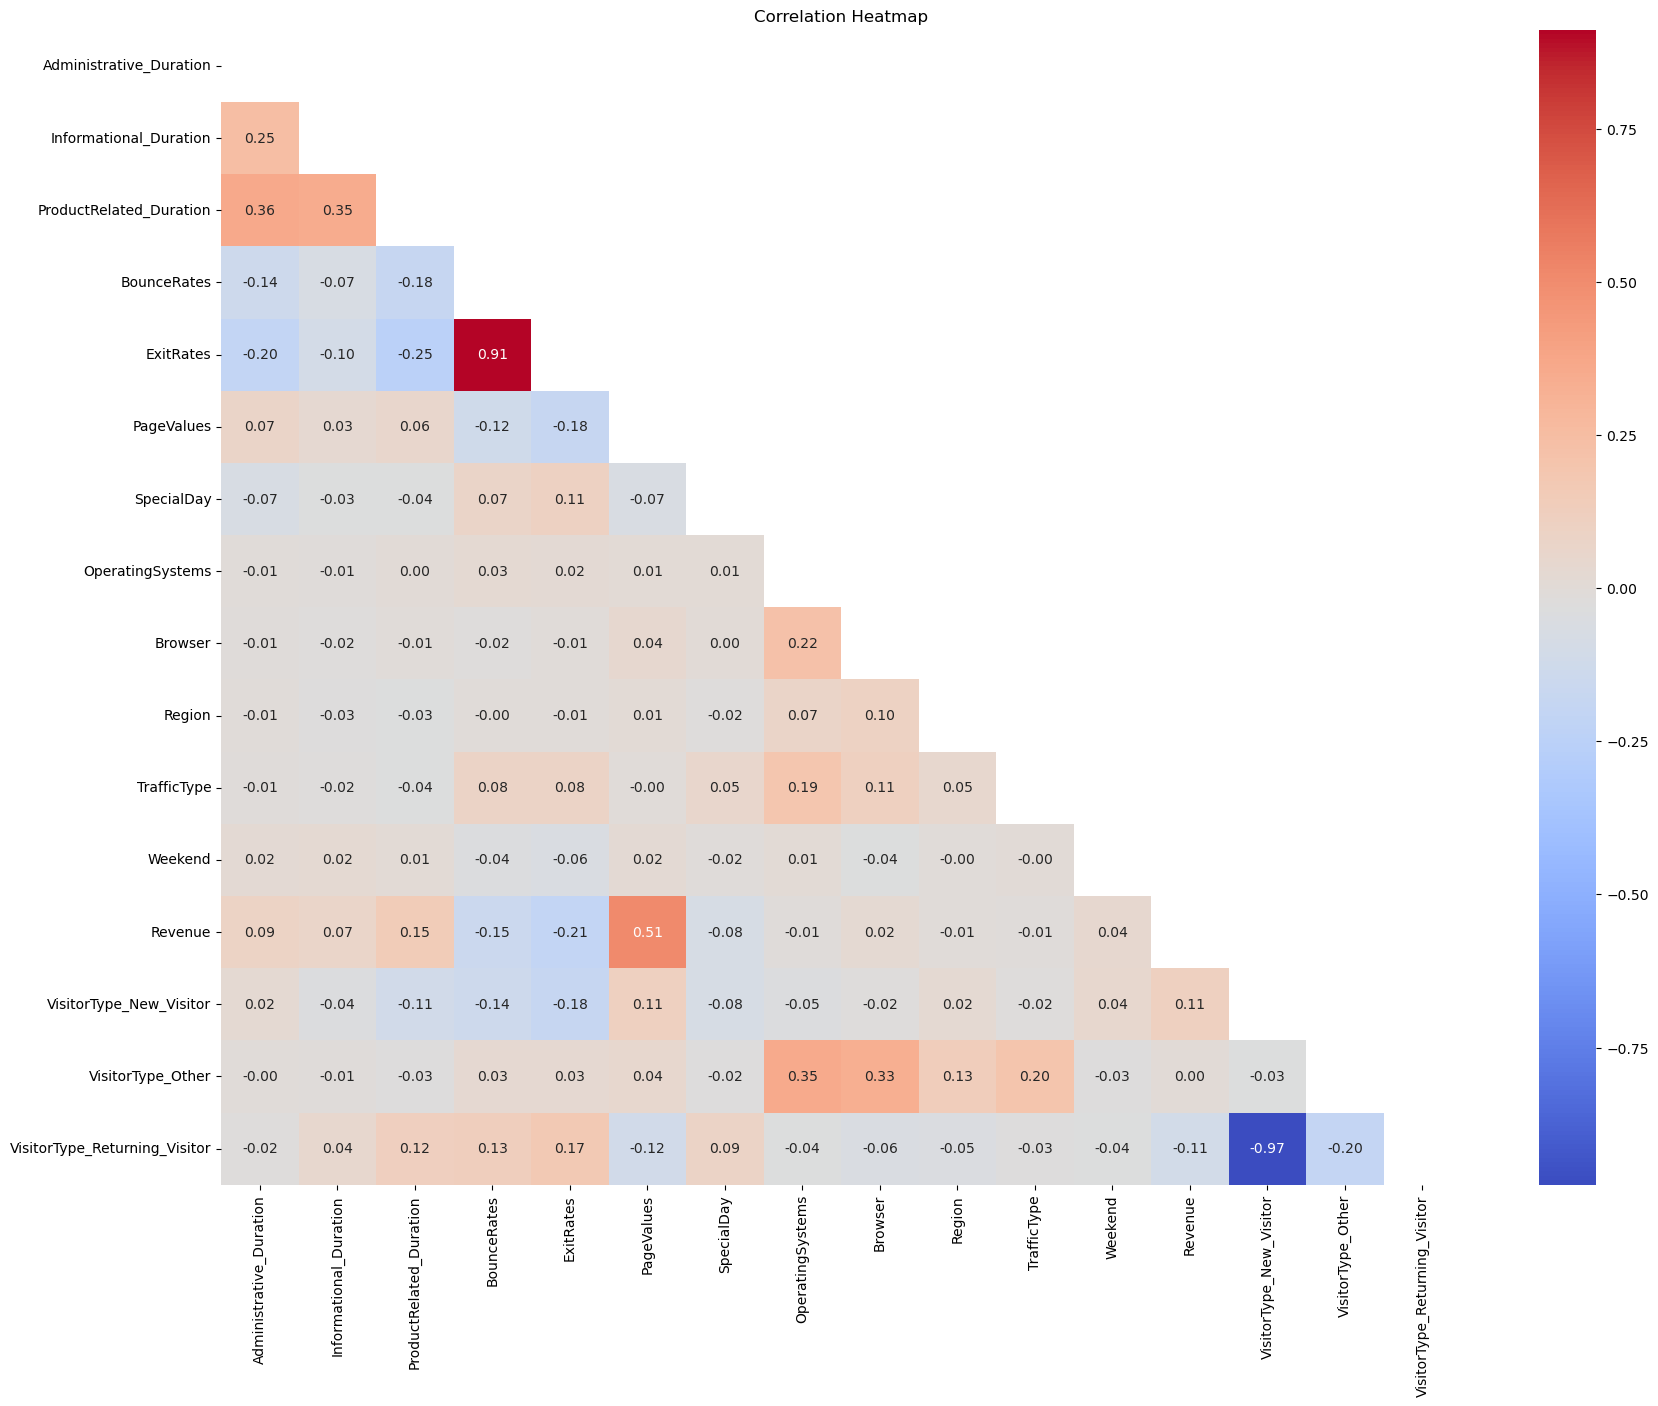

In [203]:
correlation_matrix = df_final.corr(numeric_only=True)
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(20, 15))
# Apply the mask in the heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Correlation**

Our target "Revenue" is higly correlated PageValue

****Feature engneering****

Summary:    
One hot encoding it used to convert columns "Weekend" and "Revenue" into binary 0/1.  
Dummies are used for column "VisitorType".   
While feature scaling is not necessery for alot of models, all numerical columns will be scaled to enable use of AdaBoost and SVC. RandomForest isnt hurt by useing scaled values either.
 

In [201]:
#Rewriting true/false features to binary 1/0
binary_columns = ['Weekend', 'Revenue']
for column in binary_columns:
    df_final[column] = df_final[column].replace({'True': 1, 'False': 0})

df_final[binary_columns] = df_final[binary_columns].astype(int)
#getting dummy variables
df_final = pd.get_dummies(df_final, dtype=int)

C:\Users\m_was\AppData\Local\Temp\ipykernel_20580\3105988448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[column] = df_final[column].replace({'True': 1, 'False': 0})
C:\Users\m_was\AppData\Local\Temp\ipykernel_20580\3105988448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[binary_columns] = df_final[binary_columns].astype(int)


In [205]:
#saving the cleaned data
df_scaled = df_final

In [210]:
non_numerical_cols = df_scaled.select_dtypes(exclude=[np.number]).columns
numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns

In [211]:
# Scaling the numerical columns
scaler = MinMaxScaler()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

****Baselane model****

*summary:*
A RandomForestClassifier is initialized to check for baselane performance.
The aavarage accuracy of the baselane model is ~0.89 for crossvalidation! Thats great. Work well done!  

*Not so fast!*  
The relatively low recall suggests that the model is missing a significant number of positive instances in out case recognizing non revenue actions as revenue. If the recall of a model is 0.5, it means that the model is performing no better than random guessing for the positive class. In other words, randomly selecting instances and labeling them as positive would yield the same recall value as the model.

There is one major explanation to that. The imbalance of target labels. More will be discussed further on.

We still see this as baselane model and we will see where we arrive with hypertuning.




In [212]:
X = df_scaled.drop(columns=["Revenue"]).values
y = df_scaled["Revenue"].values

# Split the data into training+validation set and testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [213]:
# Running a baselane model
baselane_model = RandomForestClassifier(random_state=42)
baselane_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [216]:

# Perform cross-validation on the baseline model with default scoring (accuracy)
cv_scores_accuracy = cross_val_score(baselane_model, X_train_val, y_train_val, cv=5)
# Perform cross-validation on the baseline model with recall scoring
cv_scores_recall = cross_val_score(baselane_model, X_train_val, y_train_val, cv=5, scoring="recall")

print(f"Cross-validation accuracy scores: {cv_scores_accuracy}")
print(f"Average cross-validation accuracy score: {cv_scores_accuracy.mean()}")

print(f"Cross-validation recall scores: {cv_scores_recall}")
print(f"Average cross-validation recall score: {cv_scores_recall.mean()}")

Cross-validation accuracy scores: [0.89494834 0.89207807 0.89552239 0.90178059 0.88914417]
Average cross-validation accuracy score: 0.8946947100753027
Cross-validation recall scores: [0.54477612 0.55970149 0.4738806  0.54681648 0.48134328]
Average cross-validation recall score: 0.5213035943876125


Accuracy: 0.88929719797887
Precision: 0.7605042016806722
Recall: 0.4958904109589041


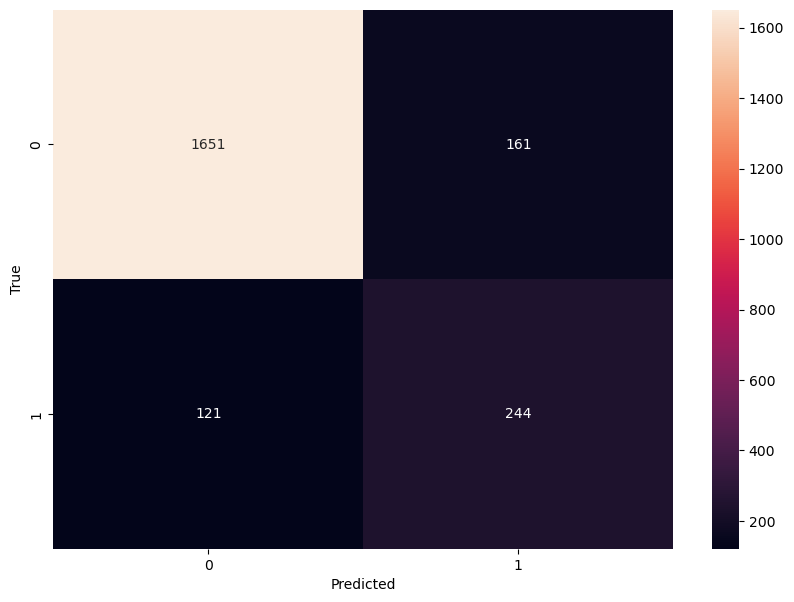

In [45]:
y_val_pred = baselane_model.predict(X_val)

# Calculate metrics for the validation set
baselane_accuracy = accuracy_score(y_val, y_val_pred)
baselane_precision = precision_score(y_val, y_val_pred)
baselane_recall = recall_score(y_val, y_val_pred)
baselane_f1_score = f1_score(y_val, y_val_pred)

print(f"Accuracy: {baselane_accuracy}")
print(f"Precision: {baselane_precision}")
print(f"Recall: {baselane_recall}")

# Compute confusion matrix for the validation set
baselane_cm = confusion_matrix(y_val, y_val_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(baselane_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Feature importance in baselane model**

PageValues appeares to be the single most important feature at this point.


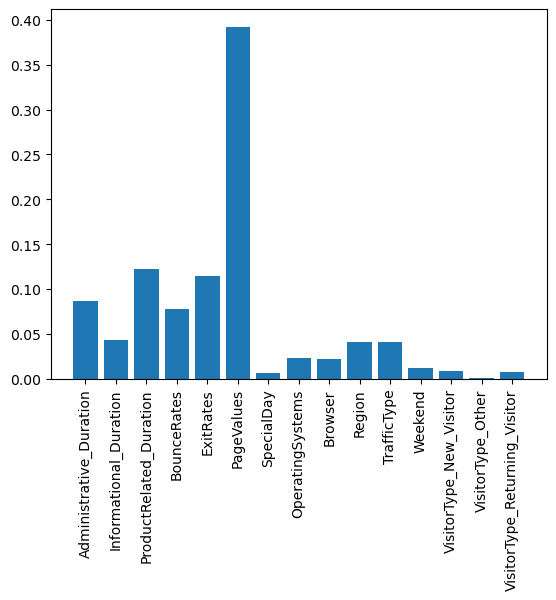

In [46]:
feature_column_names = df_scaled.drop(columns=["Revenue"]).columns.tolist()
plt.bar(feature_column_names, baselane_model.feature_importances_);
plt.xticks(rotation=90);
plt.show()

**Focusing on top important features**

In [217]:
column_names = [col for col in df_final.columns if col != 'Revenue']

In [218]:
# List of features to exclude
exclude_features = [
       'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Weekend', 'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor']  # replace with your actual feature names

# Create a list of features to include
include_features = [f for f in column_names if f not in exclude_features]

# Split the data into train and validation sets
df_train, df_val, y_train, y_val = train_test_split(df_scaled.drop('Revenue', axis=1), df_scaled['Revenue'], test_size=0.2, random_state=42)

# Create the new train and validation sets
X_train_new = df_train[include_features]
X_val_new = df_val[include_features]

In [219]:

# Train a new Random Forest model
rf_new = RandomForestClassifier(random_state=42)
rf_new.fit(X_train_new, y_train)

# Make predictions on the validation set
predicted_rf_new = rf_new.predict(X_val_new)

# Calculate the accuracy of the new model
accuracy_new = accuracy_score(y_val, predicted_rf_new)

print(f"Accuracy of new model: {accuracy_new}")

# Calculate the confusion matrix
cm = confusion_matrix(y_val, predicted_rf_new)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print the classification report
cr = classification_report(y_val, predicted_rf_new)
print("\nClassification Report:")
print(cr)

Accuracy of new model: 0.8929719797887
Confusion Matrix:
[[1742   99]
 [ 134  202]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1841
         1.0       0.67      0.60      0.63       336

    accuracy                           0.89      2177
   macro avg       0.80      0.77      0.79      2177
weighted avg       0.89      0.89      0.89      2177




****Data inbalance****

According to googles foundational course:
https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data#:~:text=A%20classification%20data%20set%20with,smaller%20proportion%20are%20minority%20classes.

Degree of imbalance	Proportion of Minority Class
Mild	20-40% of the data set
Moderate	1-20% of the data set
Extreme	<1% of the data set

In our case minority class  is 15,38% of the data set, meaning the inbalance is moderate and should be handled properly.

SMOTE oversampling will be used.


When using techniques like SMOTE with cross-validation, we need to be careful to avoid data leakage. Data leakage can occur if you oversample before cross-validation, effectively duplicating some data in the training set into the validation set. To avoid this, I perform oversampling within each cross-validation iteration. This ensures that the synthetic samples generated by SMOTE are created only from the training set of that iteration.


*Disclaimer*:
Ill use imblearn pipeline resampling techniques like SMOTE, it's recommended to use imblearn.pipeline.Pipeline instead of sklearn.pipeline.Pipeline. This ensures that resampling is correctly applied during each fold of cross-validation.

*F1-score*
What we are trying to achieve with the F1-score metric is to find an equal balance between precision and recall, which is extremely useful in most scenarios when we are working with imbalanced datasets (i.e., a dataset with a non-uniform distribution of class labels).

In [221]:
X = df_scaled.drop(columns=["Revenue"]).values
y = df_scaled["Revenue"].values

# Split the data into training+validation set and testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [225]:
feature_column_names = df_scaled.drop(columns=["Revenue"]).columns.tolist()

***Training RF***

*summary*
With smoting and some hypertuning we arrive at 
Accuracy (0.89):
The model correctly predicted the class for 89% of the instances.  

Recall for the True Class (0.80):  
Out of all actual positive instances, the model correctly identified 80% of them.  

F1-Score for the True Class (0.70):  
The F1-score combines precision and recall, providing a balanced measure of the model's performance for the true class. A score of 0.70 indicates a reasonable balance between correctly identifying positive instances and avoiding false positives.

Average Cross-Validation Score (F1-Score) (0.66):  
During training, the model achieved an average F1-score of 0.66 across different subsets of the data. This score represents the model's ability to generalize to new, unseen data.

Feature importance still shows PageValue as absolutly the most important feature.

In [222]:
from imblearn.pipeline import Pipeline

model_rf = RandomForestClassifier(random_state=42)
resampling_rf = SMOTE(random_state=42) 
#over sampling data useing pipeline
pipeline = Pipeline([('SMOTE', resampling_rf), 
                     ('Random Forest Classifier', model_rf)])

# Define parameter grid
param_grid_rf = {
    'Random Forest Classifier__n_estimators': [50, 100, 200],
    'Random Forest Classifier__max_features': ['sqrt', 'log2'],
    'Random Forest Classifier__max_depth': [5, 10],
    'Random Forest Classifier__min_samples_split': [2, 5],
    'Random Forest Classifier__min_samples_leaf': [1, 2],
}

# Define grid search
grid_search_rf = GridSearchCV(pipeline, 
                           param_grid_rf, 
                           cv=5, 
                           scoring='f1',
                           verbose=1,
                           )

# Fit grid search
grid_search_rf.fit(X_train_val, y_train_val)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      1812
         1.0       0.63      0.80      0.70       365

    accuracy                           0.89      2177
   macro avg       0.79      0.85      0.82      2177
weighted avg       0.90      0.89      0.89      2177

Cross-validation scores: [0.67286822 0.65749235 0.65048544 0.65605096 0.67401575]
Average cross-validation score: 0.6621825424266075


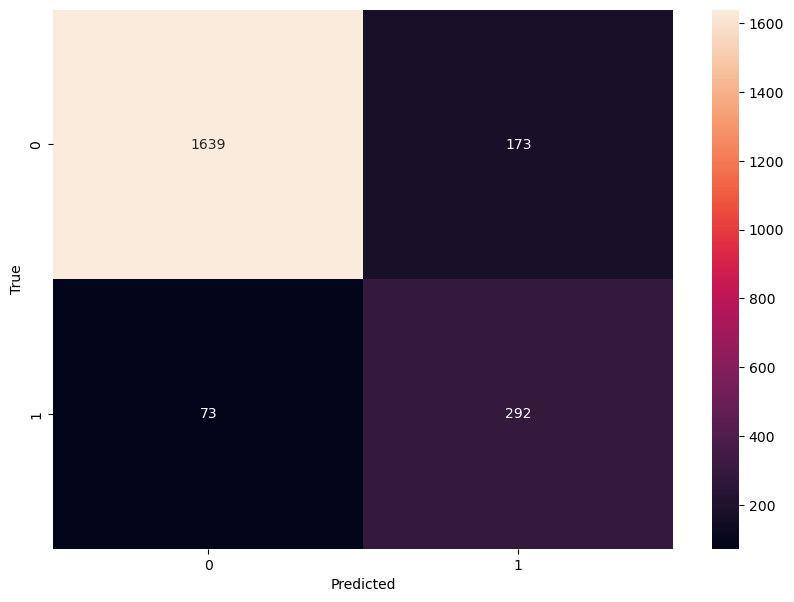

In [228]:
# Use the best estimator from the grid search to make predictions on the validation set
y_val_pred_rf = grid_search_rf.best_estimator_.predict(X_val)

# Calculate metrics for the validation set
report_rf = classification_report(y_val, y_val_pred_rf)
print(report_rf)

# Perform cross-validation
scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train_val, y_train_val, cv=5, scoring='f1')
print(f"Cross-validation scores: {scores_rf}")
print(f"Average cross-validation score: {scores_rf.mean()}")

# Compute confusion matrix. Create a heatmap from the confusion matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

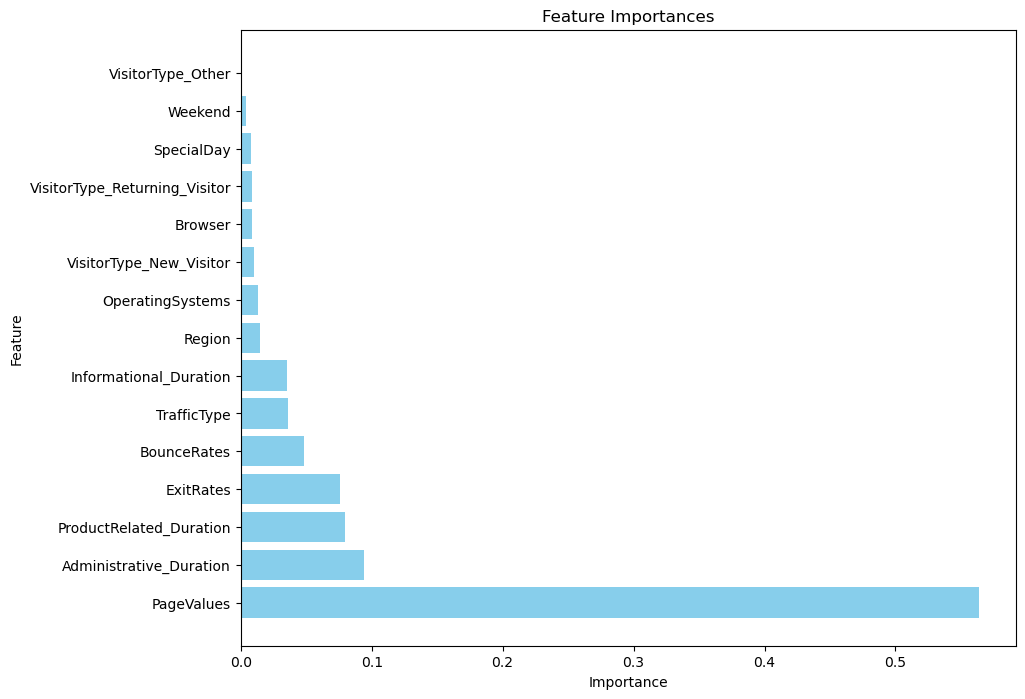

In [233]:
# Get the feature importances
feature_importances = grid_search_rf.best_estimator_.named_steps['Random Forest Classifier'].feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'feature': feature_column_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

***Training AdaBoost***

*summary*

With smoting and some hypertuning we arrive at 
Accuracy (0.87):
The model correctly predicted the class for 87% of the instances.  Which is lower than RF.

Recall for the True Class (0.76):  
Out of all actual positive instances, the model correctly identified 76% of them.  

F1-Score for the True Class (0.66):  
The F1-score combines precision and recall, providing a balanced measure of the model's performance for the true class. A score of 0.66 is lower than RF model.

Average Cross-Validation Score (F1-Score) (0.66):  
During training, the model achieved an average F1-score of 0.66 across different subsets of the data. This score represents the model's ability to generalize to new, unseen data and its very similar to RF.

In [103]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

adaboost = AdaBoostClassifier(random_state=42)
# Define pipeline
pipeline_ada = Pipeline([('SMOTE', 
                      SMOTE(random_state=42)), 
                      ('AdaBoostClassifier', adaboost)])

# Define parameter grid
params_adaboost = {
    'AdaBoostClassifier__n_estimators': [50, 100, 200],
    'AdaBoostClassifier__learning_rate': [0.01, 0.1, 1.0]
}

# Define grid search
grid_search_ada = GridSearchCV(pipeline_ada,  
                           params_adaboost, 
                           cv=5, 
                           scoring='f1',  
                           ) 

# Fit grid search
grid_search_ada.fit(X_train_val, y_train_val)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SMOTE', SMOTE(random_state=42)),
                                       ('AdaBoostClassifier',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'AdaBoostClassifier__learning_rate': [0.01, 0.1, 1.0],
                         'AdaBoostClassifier__n_estimators': [50, 100, 200]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1812
           1       0.58      0.76      0.66       365

    accuracy                           0.87      2177
   macro avg       0.76      0.82      0.79      2177
weighted avg       0.89      0.87      0.87      2177

Cross-validation scores: [0.67075038 0.65067466 0.66040689 0.6572327  0.66978193]
Average cross-validation score: 0.6617693134285492


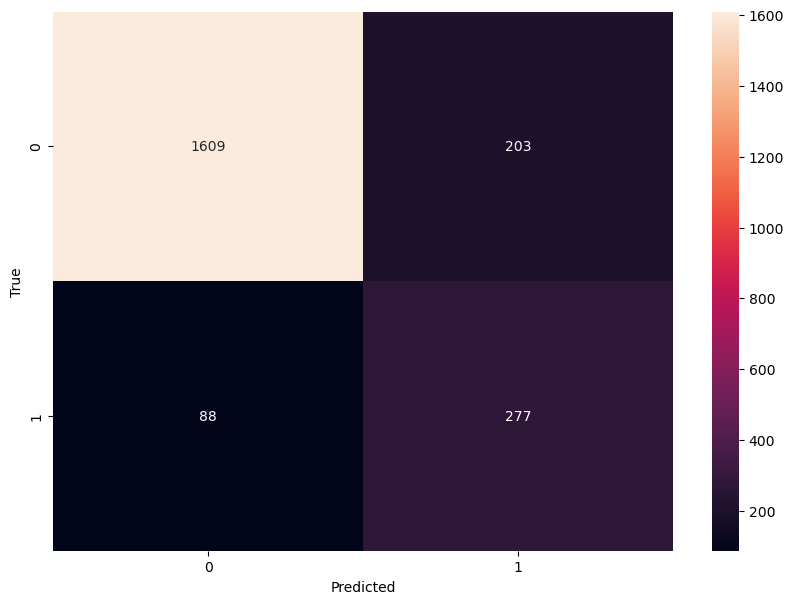

In [102]:
# Use the best estimator from the grid search to make predictions on the validation set
y_val_pred_ada = grid_search_ada.best_estimator_.predict(X_val)

# Calculate metrics for the validation set
report_ada = classification_report(y_val, y_val_pred_ada)
print(report_ada)

# Perform cross-validation
scores_ada = cross_val_score(grid_search_ada.best_estimator_, X_train_val, y_train_val, cv=5, scoring='f1')
print(f"Cross-validation scores: {scores_ada}")
print(f"Average cross-validation score: {scores_ada.mean()}")
# Compute confusion matrix
cm_ada = confusion_matrix(y_val, y_val_pred_ada)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ada, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

***Training SVC***  
*summary*  
Accuracy (0.87):  
Recall for the True Class (0.70)     
F1-Score for the True Class (0.65)  
Average Cross-Validation Score (F1-Score) (0.65)  


In [105]:
from sklearn.svm import SVC

# Define the parameter grid for grid search
params_svm = {
    'SVC__C': [0.1, 1, 10],
    'SVC__kernel': ['linear', 'rbf'],
    'SVC__gamma': ['scale', 'auto'],
}

# Initialize SVC with a random state
svc = SVC(random_state=42)

# Define pipeline
pipeline_svm = Pipeline([('SMOTE', SMOTE(random_state=42)), ('SVC', svc)]) 

# Define grid search
grid_search_svm = GridSearchCV(pipeline_svm, 
                            params_svm, 
                            cv=5, 
                            scoring='f1')


grid_search_svm.fit(X_train_val, y_train_val)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SMOTE', SMOTE(random_state=42)),
                                       ('SVC', SVC(random_state=42))]),
             param_grid={'SVC__C': [0.1, 1, 10],
                         'SVC__gamma': ['scale', 'auto'],
                         'SVC__kernel': ['linear', 'rbf']},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1812
           1       0.60      0.70      0.65       365

    accuracy                           0.87      2177
   macro avg       0.77      0.81      0.79      2177
weighted avg       0.88      0.87      0.88      2177

Cross-validation scores: [0.67326733 0.65483871 0.64070796 0.64716007 0.65993266]
Average cross-validation score: 0.6551813459582677


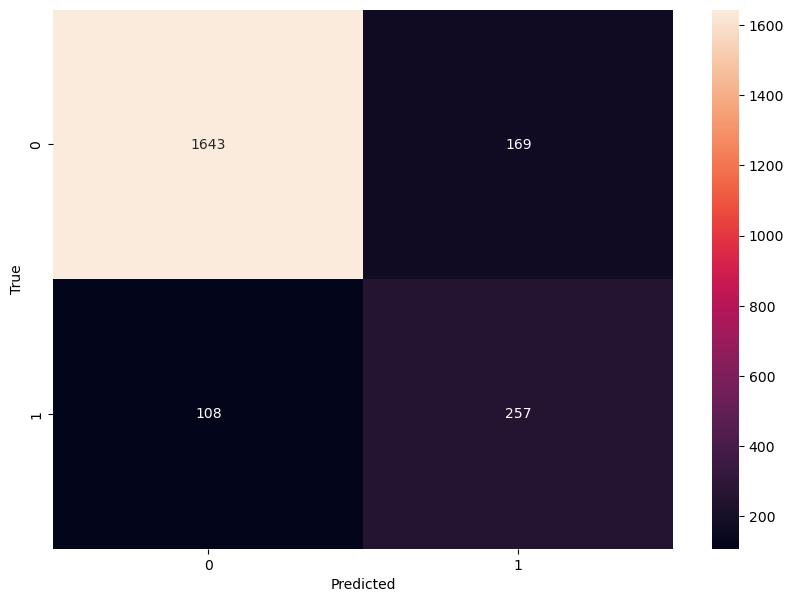

In [106]:
y_val_pred_svm= grid_search_svm.best_estimator_.predict(X_val)

# Calculate metrics for the validation set
report_svm = classification_report(y_val, y_val_pred_svm)
print(report_svm)

# Perform cross-validation
scores_svm = cross_val_score(grid_search_svm.best_estimator_, X_train_val, y_train_val, cv=5, scoring='f1')
print(f"Cross-validation scores: {scores_svm}")
print(f"Average cross-validation score: {scores_svm.mean()}")
# Compute confusion matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

***Model comparison***

All the models achive high accuracy. In our case its not the most important metrics. As mentioned before The F1 score is less affected by class imbalance, as it considers both false positives and false negatives. It provides a more reliable measure of a model's performance in such scenarios.

In the future if the model would go into the production, the imbalance of data will still propobly hold. Most visitors wont actually make a purchase. Therfore F1 score will remain relevant. 

In comparasion all the model achive very similar F1 score on cross validation avrages.

I would still consider the random forest classifier to be the true "winner" of the bunch. Since it achives highest recall meaning it does recognize less non-sale events as sale, compared to other models.

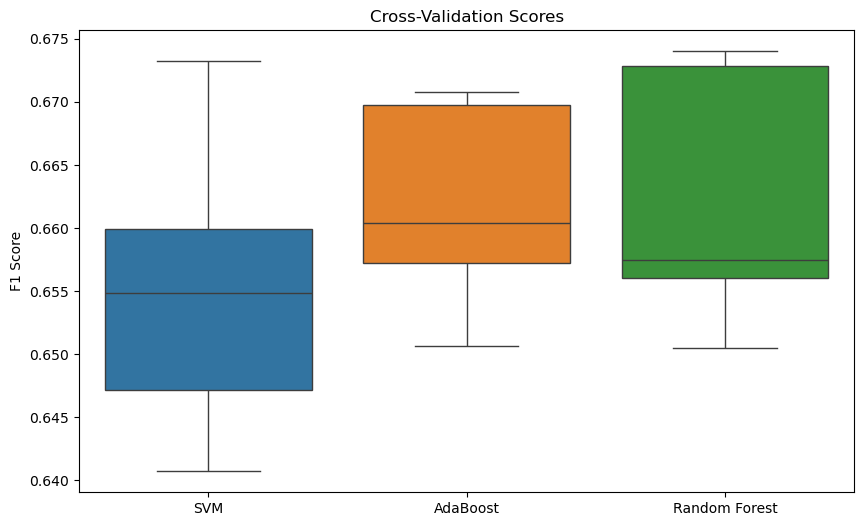

In [108]:
# Combine the scores into a list of lists
scores = [scores_svm, scores_ada, scores_rf]
models = ['SVM', 'AdaBoost', 'Random Forest']

# Create a DataFrame from the scores
df_scores = pd.DataFrame(scores, index=models).T

# Create a boxplot of the scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scores)
plt.title('Cross-Validation Scores')
plt.ylabel('F1 Score')
plt.show()

**ERROR ANALYSIS**

In [235]:
df_val = pd.DataFrame(X_val, columns=column_names)
df_val['actual'] = y_val
df_val['predicted_svm'] = y_val_pred_svm
df_val['predicted_ada'] = y_val_pred_ada
df_val['predicted_rf'] = y_val_pred_rf

errors_svm = df_val[df_val['actual'] != df_val['predicted_svm']]
errors_ada = df_val[df_val['actual'] != df_val['predicted_ada']]
errors_rf = df_val[df_val['actual'] != df_val['predicted_rf']]

# Calculate the error rate for each model
error_rate_svm = len(errors_svm) / len(df_val)
error_rate_ada = len(errors_ada) / len(df_val)
error_rate_rf = len(errors_rf) / len(df_val)

# Display the error rates
print("SVM Error Rate:", error_rate_svm)
print("AdaBoost Error Rate:", error_rate_ada)
print("Random Forest Error Rate:", error_rate_rf)

SVM Error Rate: 0.12723932016536518
AdaBoost Error Rate: 0.13367018833256775
Random Forest Error Rate: 0.11299954065227377


**Final assessment**  

*Introduction*  

The objective was to develop a machine learning model capable of predicting whether a visitor to an online retail site will complete a purchase. This predictive tool can assist marketing teams in refining their strategies for promotions, pricing, personalization, and campaigns, thereby enhancing the probability of conversion and, consequently, boosting revenue.

*Current situation*  

The provided data contained information about visits to our e-commerce store. A total of 12,330 sessions were recorded, with each session corresponding to a single user's activity on our platform over a one-year period. Unfortunately, approximately 12% of the data was invalid in some capacity and had to be removed.

We will use the term "conversion rate" significantly. As a reminder, in e-commerce, the conversion rate is the percentage of website visitors who purchased something from your online store.

The historical data reveals some interesting issues that need to be addressed:

*We observe similar conversion rates across different regions, but Region 1 stands out as our most important region, unequal to the others.

*Traffic of Type 2 is the most common and also the biggest revenue stream of this type.

*As of now, sales are not dependent on special holiday days.

*The operating system and type of browser have an influence on sales numbers and conversion.

*The conversion rate of new customers is higher than that of returning customers.

*Proposed solutions:* 

*Expand into regions where we have a lower number of users. Implement targeted marketing campaigns for regions with lower reach. People may like our site but may not know about it.

*Strive to optimize user experience across different browsers and operating systems.

*According to some studies, "Depending on your industry, studies suggest that acquiring a first-time customer can cost between 5 and 25 times as much as retaining an existing one." We need to improve the conversion rate of our returning customers. This can be achieved through loyalty programs or bonuses on each new purchase.

*Holiday special campagines to drive the sales and creat more buzz.

**The implemantation of machine learning model**

The different machine learning models were trained on the data. Technically, a model can be used in a real-time system to analyze online shopper behavior and predict the visitor's shopping intent.

In the first step, we predict the visitor's purchasing intention using pageview data collected during the visit, along with session and user information. These extracted features are then utilized as input for one of our models. To enhance the performance and scalability of the classifiers, we employ oversampling and feature selection preprocessing steps.

The question is, how feasible is this?

At first glance, we achieve a high accuracy of 90%, meaning we correctly predict users' intentions in 100 predictions made by the model, approximately 90 are accurate.

However, since the nature of our business and the reality of consumer behavior create imbalance in our data, with most visits (84.5%) not resulting in a sale. This is how an accuracy of 90% is achieved; non-sale events are so common that even randomly picking and classifying user sessions (while still maintaining the % ratio) would yield similar results.

We are interested in when a session will actually lead to a sale. In our best model (RF), we were able to achieve a recall score of 80%, meaning the model can find 80% of the actual positive cases, and a so-called F1-score of 67% on unseen data. The F1 score takes both precision and recall into account to give us a single number that represents the overall performance of the model. A higher F1 score means the model is both accurate in identifying positive cases and good at finding all the positive cases that are there.

The numbers may not be overwhelmingly enthusiastic, but it still possesses significant prediction power for sale events. These findings are important for our marketing, product recommendations, and website improvements. With our model's predictions, we can better target potential customers with our promotions. We can also customize the online shopping experience by suggesting products that match each visitor's interests, boosting sales and revenue.


Although the metrics show promise, we must recognize the limitations and challenges we faced. An important issue is the imbalance in our data, where non-sale events are much more common (84.5%). This could affect the reliability of our model and lead to biased results. Also, the model may perform differently on new data, underlining the importance of continuous validation and testing.

